In [64]:
from Authenticator import read_auth
import matplotlib.pyplot as plt
from datetime import datetime
import ReadFromDB as RDB
import seaborn as sns
import pandas as pd
import numpy as np
import scipy as sc
import warnings
import time


%matplotlib inline
%config InlineBackend.figure_format = 'retina'
warnings.filterwarnings('ignore')
sns.set(style="dark")

In [11]:
# import sys
# !conda install --yes --prefix {sys.prefix} seaborn

# reload after changes have been made
from importlib import reload
reload(RDB)
for i in dir(RDB)[8:]:
    print(i,end=', ')

create_station_dictionary, get_static_data, pd, read_auth, read_weather, station, station_dict_row, 

### Importing and cleaning Data

In [12]:
static_data = RDB.get_static_data()
station_numbers = list(static_data['number'].astype(int))

In [13]:
weather = RDB.read_weather(5)
# weather.head(1)

In [127]:
# read data from database
station_data = RDB.station(5)

# remove any data where the station is closed
station_data = station_data[station_data.status=='OPEN']

# convert timestamps from milliseconds to seconds and change type to int
station_data.last_updated = station_data.last_updated.apply(lambda x: int(x)/1000)

#convert the timestamps to date_times
convert = (lambda x : datetime.utcfromtimestamp(x).strftime('%Y-%m-%d %H:%M:%S'))
station_data.last_updated = station_data.last_updated.apply(convert)
station_data.last_updated = pd.to_datetime(station_data.last_updated)

# set timestamp as index
station_data = station_data.set_index('last_updated')
station_data.index.name='time'

# sorting indices (should be redundant)
station_data.sort_index(inplace=True)

# resampling data to every half hour
timestep = 60
station_data = station_data.resample(f'{timestep}T').mean()

# drop NaN, round float to int. 
station_data = station_data.dropna()
station_data = station_data.round(0).astype(int)

# copy of indices
index = station_data.index.values

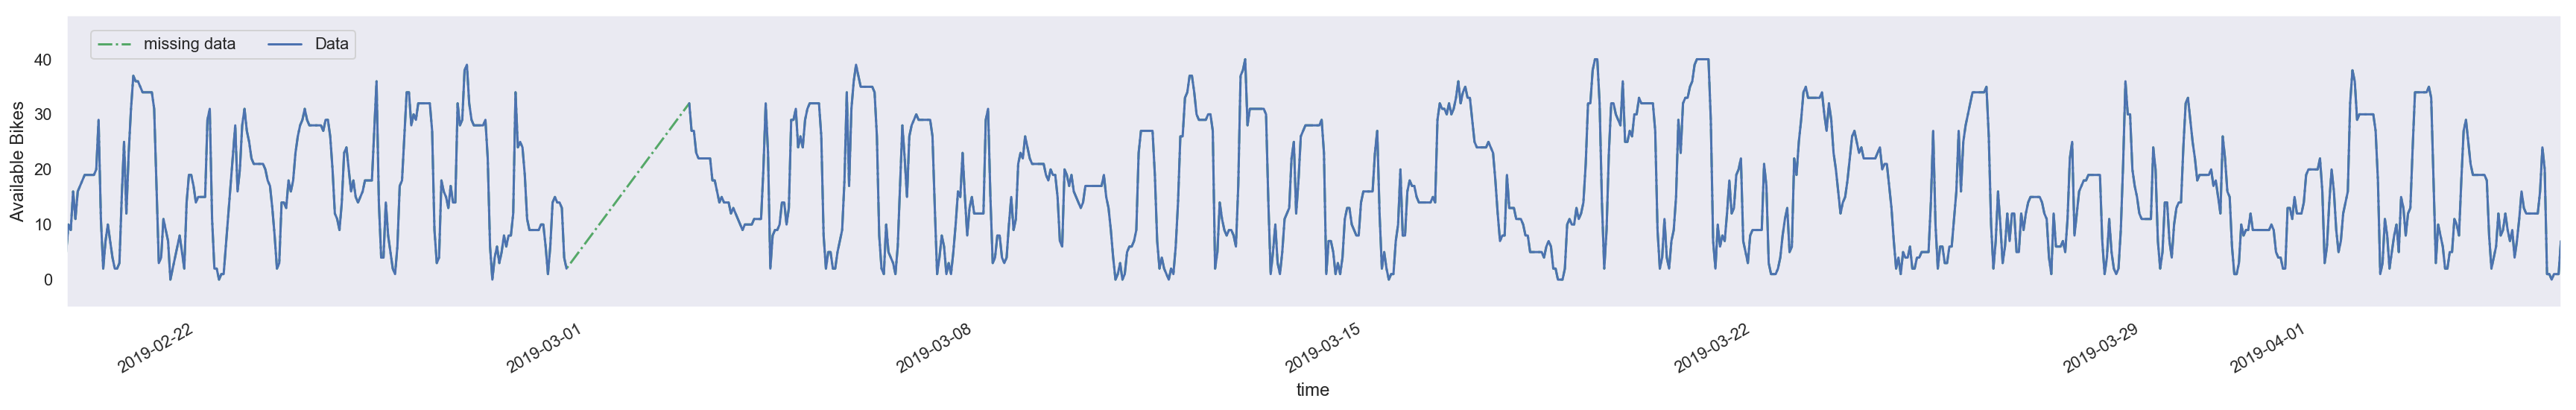

In [128]:
plt.figure(figsize=(30,4))
## some data is missing. scraper stopper working.
plot = station_data['available_bikes'].plot(style='g-.') 
plot = station_data['available_bikes'].loc[:'2019-03-01 00:15:00'].plot(style='b-')
plot = station_data['available_bikes'].loc['2019-03-01 00:15:00':].plot(style='b-')

plt.ylabel('Available Bikes')
plt.ylim([-5,48])
plt.legend(['missing data','Data'], bbox_to_anchor=(0.01, 0.85, 1., .102), loc=3, ncol=2, borderaxespad=0.)

### Data preparation for Models

Average number of bikes per station

#### Distritbution

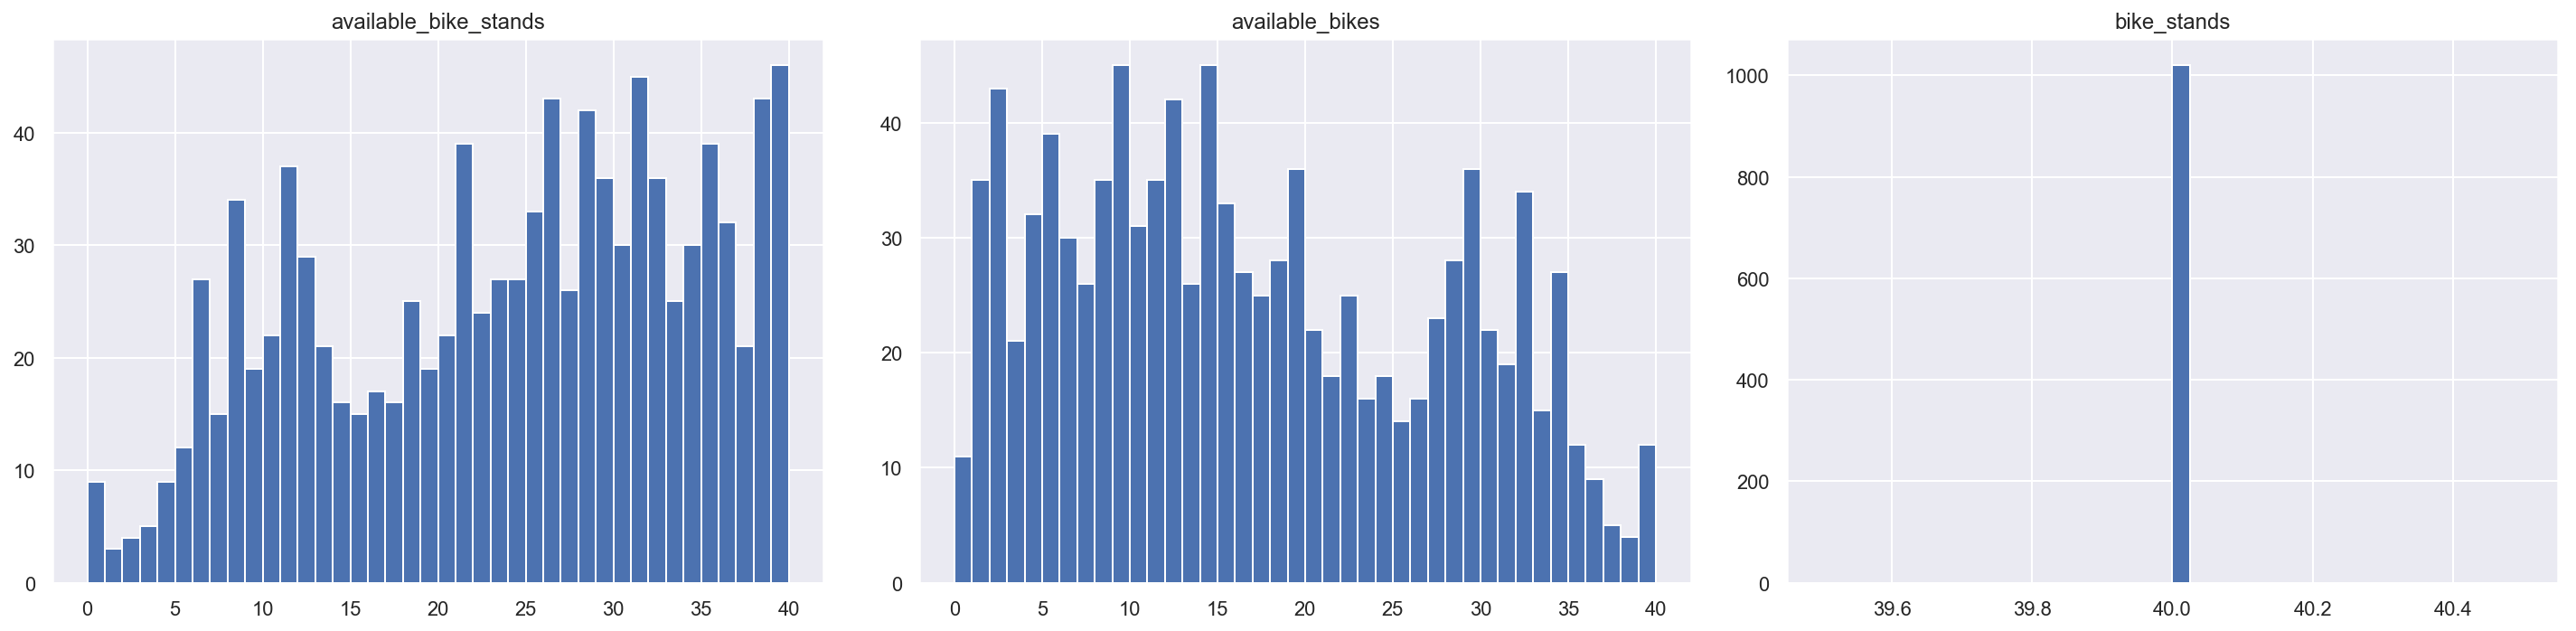

In [122]:
# set no. bins to the number of bike stands.
nbins = max(station_data['bike_stands'].values)

# Plot histogram
station_data.hist(layout=(1,3), figsize =(20,5), bins = nbins)
plt.tight_layout()

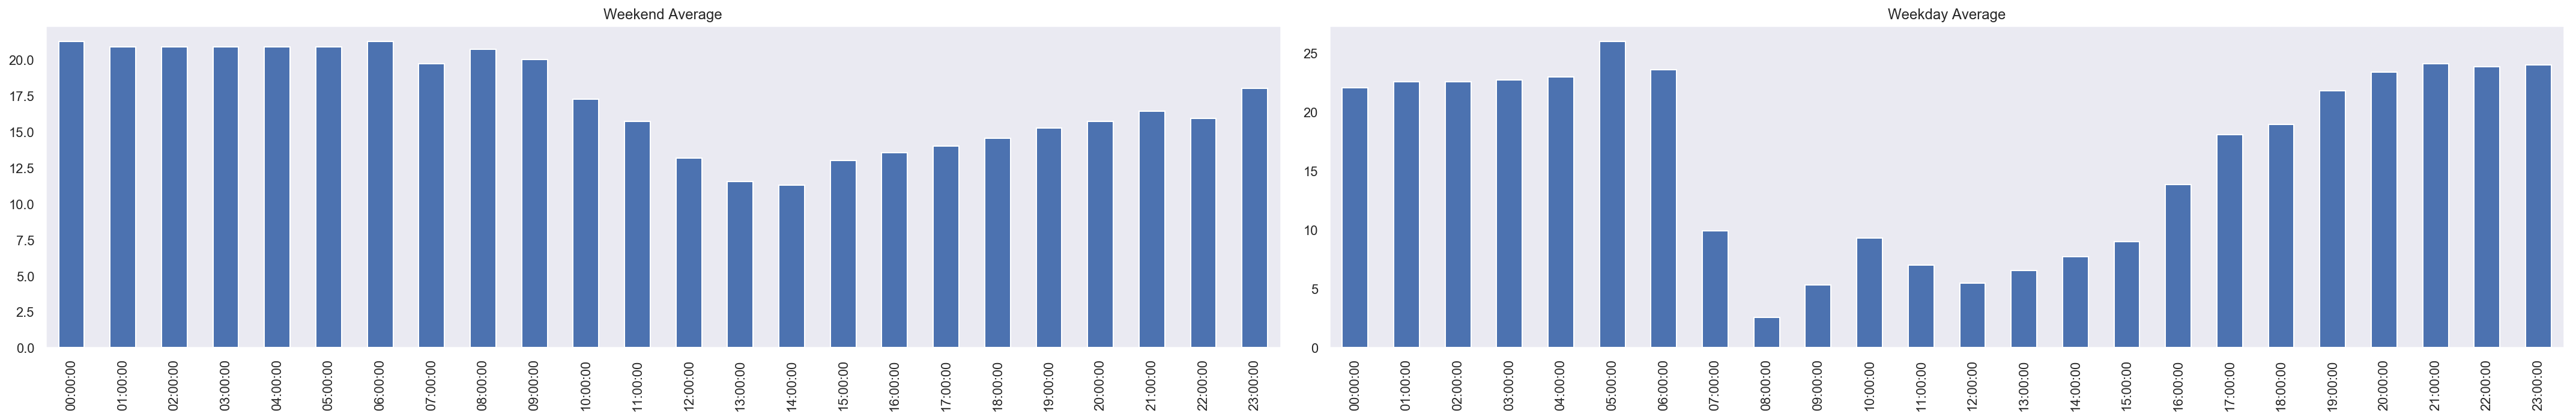

In [230]:
avail_bikes = station_data['available_bikes']

# index of data by weekday/ weekend
weekend = np.where(avail_bikes.index.weekday < 5, 'Weekday','Weekend')
Data_by_day = avail_bikes.groupby([weekend])

# Mean per hour each day
Data_by_day_mean = avail_bikes.groupby([weekend, station_data.index.time]).mean()

fig, ax = plt.subplots(1,2, figsize = (30,5))
fig = Data_by_day_mean.ix['Weekend'].plot(kind='bar', ax = ax[0], title='Weekend Average')
fig = Data_by_day_mean.ix['Weekday'].plot(kind='bar', ax = ax[1], title='Weekday Average')

plt.tight_layout() 

**Histogram shows clearly that the data is bimodal. There are two separate means of bikes available meaning time series analysis will not work. One was to fix this is to split the data into weekdays and weekends. 
The Weekends have a separate mean to the weekdays.**

#### Autocorrelation / Partial Autocorrelation

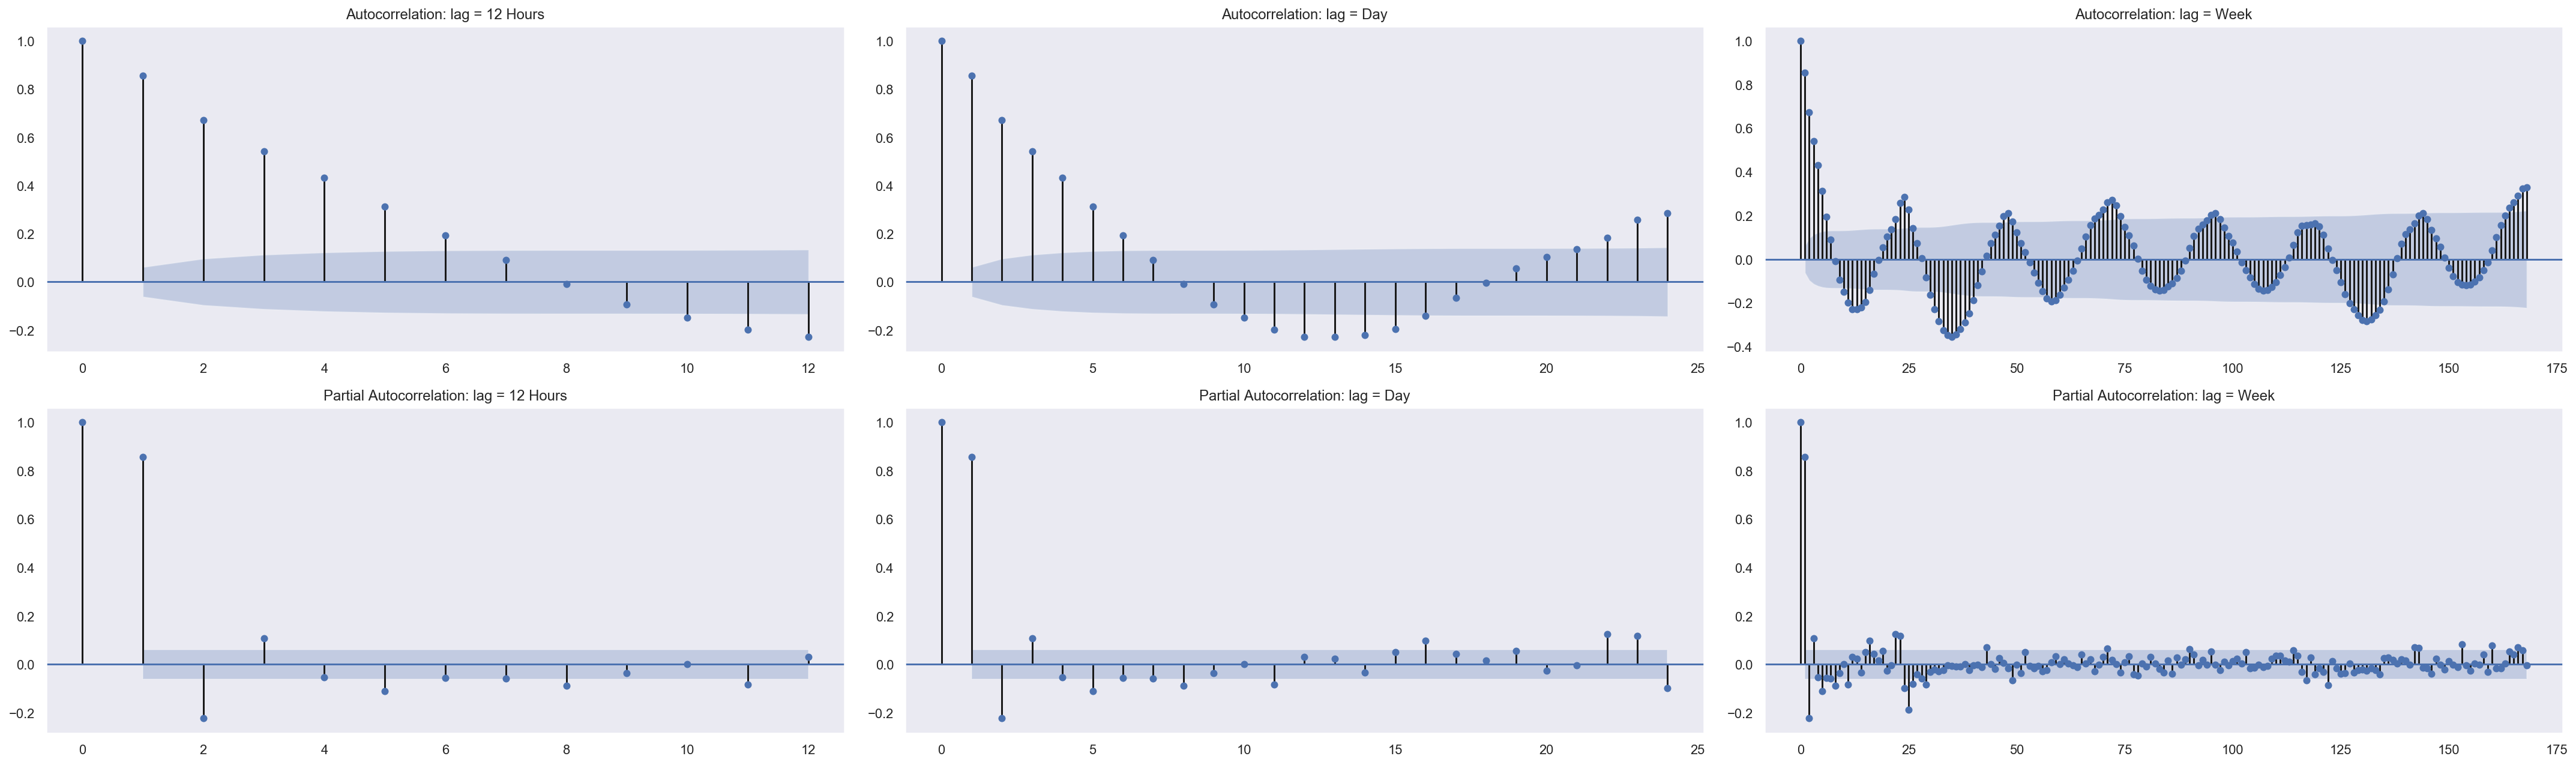

In [123]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

samples_per_hour = timestep/60
samples_per_day = samples_per_hour * 24 
samples_per_week = samples_per_day * 7

f, axes = plt.subplots(2,3, figsize = (30,9))

f = plot_acf( station_data['available_bikes'], lags = 12*samples_per_hour, title='Autocorrelation: lag = 12 Hours', ax=axes[0, 0]);
f = plot_pacf(station_data['available_bikes'], lags = 12*samples_per_hour, title='Partial Autocorrelation: lag = 12 Hours',ax=axes[1, 0]);

f = plot_acf( station_data['available_bikes'], lags = samples_per_day, title='Autocorrelation: lag = Day',ax=axes[0, 1]);
f = plot_pacf(station_data['available_bikes'], lags = samples_per_day, title='Partial Autocorrelation: lag = Day',ax=axes[1, 1]);

f = plot_acf( station_data['available_bikes'], lags = samples_per_week,title='Autocorrelation: lag = Week',ax=axes[0, 2]);
f = plot_pacf(station_data['available_bikes'], lags = samples_per_week,title='Partial Autocorrelation: lag = Week', ax=axes[1, 2]);

plt.tight_layout()

**The above graphs show the autocorrelation function applied to the available bikes data series.**
Autocorrelation plots are often used for checking randomness in time series. This is done by computing autocorrelations for data values at varying time lags. If time series is random, such autocorrelations should be near zero for any and all time-lag separations. If time series is non-random then one or more of the autocorrelations will be significantly non-zero. The horizontal lines displayed in the plot correspond to 95% and 99% confidence bands. The dashed line is 99% confidence band. See the Wikipedia entry for more about autocorrelation plots.

#### Splitting Data into test and training sets

In [ ]:
# split data into train and test sets. (there is a pause in data between the two conveniently it splits the data ~ 80:20)
testbikes = data['available_bikes'].loc[:'2019-03-01 00:15:00']
bikes = data['available_bikes'].loc['2019-03-01 00:15:00':]

f, axes = plt.subplots(2, 1, sharey=True, figsize=(20,6))
plt.subplots_adjust(hspace=0.3)

axes[0].set_title('Training data')
axes[0].plot(bikes,'k-')

axes[1].set_title('Testing data')
axes[1].plot(testbikes,'b-')

### Model Application

- Linear Regression
- Cosine fit
- Polynomial regression
- random forest regression
- ARIMA MODEL
    - check for time series stationarity

**Hourly Average Across Data Set**

In [ ]:
# Dan has this done. Import here -> Box plots.

**Simple Linear Regression**

In [ ]:
from sklearn.linear_model import LinearRegression

# reshape data to fit with linear regression requirements. 
x = bikes.index.values.reshape(-1,1)
y = bikes.values.reshape(-1,1)
test_x = testbikes.index.values.reshape(-1,1)

# need to change x values from datetime type to float.
x = (x - np.datetime64('1970-01-01T00:00:00Z')) / np.timedelta64(1, 's')
test_x = (test_x - np.datetime64('1970-01-01T00:00:00Z')) / np.timedelta64(1, 's')

# apply linear regression model 
LR = LinearRegression().fit(x, y)

# make predictions using model.
predictionLR = LR.predict(test_x).round(0).astype(int)

# plot results for comparison
plt.title('Simple Linear Regression')
plt.xticks(rotation=45)
plt.ylim([-5,50])

plt.plot(testbikes, label='test data')
plt.plot(testbikes.index, predictionLR,'--', label='prediction')

plt.legend(loc='upper left')

**Ridge Model for polynomial Interpolation (up to n=5)**

This model solves a regression model where the loss function is the linear least squares function and regularization is given by the l2-norm. Also known as Ridge Regression or Tikhonov regularization. This estimator has built-in support for multi-variate regression (i.e., when y is a 2d-array of shape [n_samples, n_targets]) (From Scikit-learn website)

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Ridge

# R = Ridge(alpha=0.1)
plt.figure()
plt.xticks(rotation=35)
plt.title('Ridge-Polynomial Regression')
plt.ylabel('Bikes')
plt.xlabel('Date')
plt.plot(testbikes)

for degree in range(5):
    RM = make_pipeline(PolynomialFeatures(degree), Ridge())
    RM.fit(x,y)
    PredictionRidge = RM.predict(test_x)

    plt.plot(testbikes.index.values, PredictionRidge, label=f'Polynomial of degree: {degree}')

plt.legend(bbox_to_anchor=(1,0.8))
plt.show()

This model is not useful when applied to the data set as a whole but may be useful applied to the averages generated above for each station and then used as a predictor

**Linear Regression with Gaussian Features**

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.base import BaseEstimator, TransformerMixin

class GaussianFeatures(BaseEstimator, TransformerMixin):
    """Uniformly spaced Gaussian features for one-dimensional input"""
    
    def __init__(self, N, width_factor=2.0):
        self.N = N
        self.width_factor = width_factor
    
    @staticmethod
    def _gauss_basis(x, y, width, axis=None):
        arg = (x - y) / width
        return np.exp(-0.5 * np.sum(arg ** 2, axis))
        
    def fit(self, X, y=None):
        # create N centers spread along the data range
        self.centers_ = np.linspace(X.min(), X.max(), self.N)
        self.width_ = self.width_factor * (self.centers_[1] - self.centers_[0])
        return self
        
    def transform(self, X):
        return self._gauss_basis(X[:, :, np.newaxis], self.centers_,
                                 self.width_, axis=1)
    
gauss_model = make_pipeline(GaussianFeatures(2), LinearRegression())

gauss_model.fit(x, y)

PredictionGauss = gauss_model.predict(test_x)

plt.plot(test_x, PredictionGauss)
plt.plot()

**ARIMA**

From the above plot a value for p, d is found. They are represented by the red lines. p=7, d=2

Shows the series is periodic with frequency of 7 days (lags) ? 

In [ ]:
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
import itertools

training_set = data['available_bikes'].loc[:'2019-03-29 00:00:00']
testing_set  = data['available_bikes'].loc['2019-03-29 00:00:00':]

nperiods = int(len(training_set) / ((60/timestep) * 24 * 7)) # setting weeky periods.

# model = ARIMA( training_set, order=(4,0,0))
model = sm.tsa.statespace.SARIMAX(training_set, 
                                  order = (7,0,1), 
                                  seasonal_order=(7,1,1,nperiods))
AR = model.fit()

# Predictions
# ARP = AR.predict(start=testing_set.index.values[0], end=np.datetime64('2019-04-11T18:00:00.000000000'))
# print(model_fit.summary())


In [ ]:
f, ax = plt.subplots(2,1, sharey=True, figsize = (20,8))
ax[0].plot(bikes)
# ax[0].plot(AR.fittedvalues,color='red')

# ax[1].plot(bikes)
ax[0].plot(list(AR.get_prediction()), color='red')

# MINIMISE AIC AND BIC